# Self Supervised Constrastive Learning SimCLR pipeline

### Importing Libraries

In [3]:
# !pip install pytorch-lightning
# !pip uninstall -y torchvision
# !pip install torchvision --no-cache-dir  # Reinstall a clean, compatible version

In [61]:
## Standard libraries
import os
from copy import deepcopy
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint



# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

/var/folders/ml/d5_wdzfx4b94d9n7g5j1wb_80000gn/T/ipykernel_33868/1512296812.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cpu
Number of workers: 11


<Figure size 640x480 with 0 Axes>

As in many tutorials before, we provide pre-trained models. Note that those models are slightly larger as normal (~100MB overall) since we use the default ResNet-18 architecture. If you are running this notebook locally, make sure to have sufficient disk space available.

## SimCLR
1. Data Augmentation and Dataset Creation
2. SimCLR Implementation
3. Analysing the encoder performance using tSNE and K means.

### 1. Data Augmentation and Dataset Creation for Contrastive Learning

- We have to create **2 augmented views (xi, xj) of the same input image**. These views form a positive pair, as required by the SimCLR training framework, for this:
    - We define transformation pipeline `contrast_transforms` using medical image appropriate augmentations using TorchIO. 
    - The class `ContrastiveTransformations` applies this transform pipeline twice independently for each input sample, thereby generating 2N views from N samples, which are then used to compute the contrastive loss (This is done in the `CustomDataset class`).
    - The resulting dataset, `unlabeled_data`, provides two views per sample and is used to define a SubjectLoader for contrastive training.
  

In [46]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [47]:
import torchio as tio

contrast_transforms = tio.Compose([
    tio.Lambda(np.log1p),
    tio.Resize((40, 256, 256)),
    tio.RandomFlip(axes=(0,), p=0.5),
    tio.RandomAffine(
    degrees=1,
    translation=1,
    center='origin',
    default_pad_value='mean'
),
    tio.RandomNoise(std=0.003, p=0.3),
    tio.RandomGamma(log_gamma=True, p=0.2),
])

In [48]:
contrastive_transform = ContrastiveTransformations(base_transforms=contrast_transforms, n_views=2)

In [49]:
from torch.utils.data import Dataset
import torch
import numpy as np
import torchio as tio

class Custom_Dataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __getitem__(self, idx):
        volume = np.load(self.paths[idx]).astype(np.float32)
        volume = torch.from_numpy(volume).unsqueeze(0)

        subject = tio.Subject(img=tio.ScalarImage(tensor=volume))

        if self.transform:
            view1, view2 = self.transform(subject)  
            view1 = view1['img'].data
            view2 = view2['img'].data
        else:
            view1 = volume
            view2 = volume

        return tio.Subject(
            view1=tio.ScalarImage(tensor=view1),
            view2=tio.ScalarImage(tensor=view2),
            label=0
        )

    def __len__(self):
        return len(self.paths)


In [50]:
from pathlib import Path

paths = list(Path("all_npy").rglob("*.npy"))
print(paths[:3]) # just for checking a few paths
unlabeled_data = Custom_Dataset(paths=paths, transform=contrastive_transform)

[PosixPath('all_npy/sample_0585.npy'), PosixPath('all_npy/sample_0591.npy'), PosixPath('all_npy/sample_0208.npy')]


In [58]:
print(f'The number of positive pairs: {len(unlabeled_data)}, so the total number of augmented 3D views is {2 * len(unlabeled_data)}.')

The number of positive pairs: 615, so the total number of augmented 3D views is 1230.


### 2. SimCLR implementation

Now that we have our positive pairs dataset ready, we'll start implementing our SimCLR pipeline:

- High level definition : 
    - SimCLR learns representations by maximizing agreement between differently augmented views of the same data example via a contrastive loss in the latent space. 
    - At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, we want to maximise the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$  while minimising it to all other examples in the batch.

<center width="100%">
  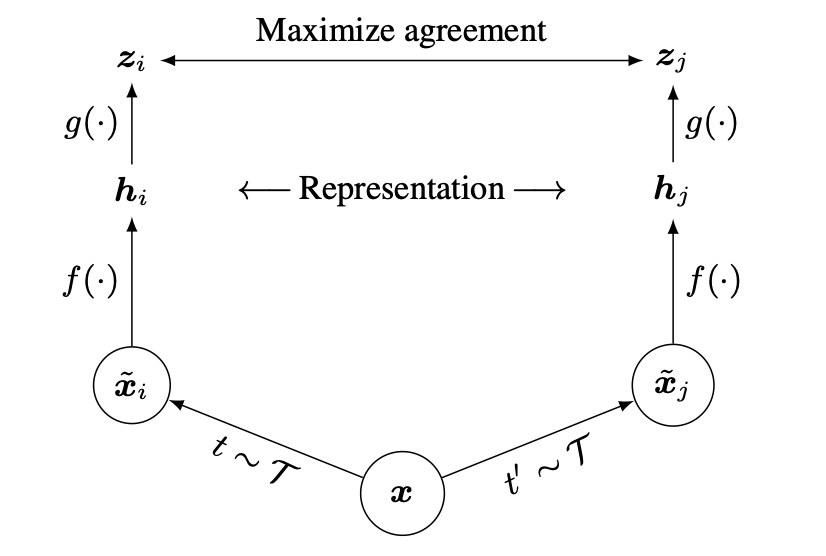
</center>

- T : `ContrastiveTransformations`
- ($\tilde{x}_i$,  $\tilde{x}_j$) : `unlabeled_data` contains these positive pairs for every original sample ${x}$ (in our case a sample means a z stack at a particular timestamp).

- Our SimCLR network is divided into 2 parts where $f(\cdot)$ is the encoder, and $g(\cdot)$ is a projection head that maps representations to space where constastive loss is applied. 
    - $f(\cdot)$ : `ConvNet3D`class 
    - $g(\cdot)$ : Non linear Multilayer perceptron with a single hidden layer. 

- The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task, this is because representations $z$ are trained to become invariant to many features that could be important for downstream tasks. Thus, Once the training is over, we remove $g(\cdot)$ and we keep the $f(\cdot)$ encoder which acts as our pre trained feature extractor, and this encoder is then used for downstream tasks, in our case classifying between WT and MUT cell types.

- `info_nce_loss` : Constrastive Cross Entropy loss where it pushes $\text z_i $ and $\text z_j $ closer in the feature space, and pushes $\text z_i $ away from the rest. This is how the model learns to cluster similar instances and separate dissimilar ones.
$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$ 
where, $
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$ is cosine similarity and $\tau$ is
 temperature parameter.

**Extra Note:** 
- **larger/wider MLPs can boost the performance considerably.**
- **Larger batch sizes and longer training time is recomended.**



In [11]:
class ConvNet3D(nn.Module):
    def __init__(self):
        super(ConvNet3D, self).__init__()
        self.Conv1 = nn.Conv3d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.Conv2 = nn.Conv3d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.Conv3 = nn.Conv3d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.BN1 = nn.BatchNorm3d(16)
        self.BN2 = nn.BatchNorm3d(32)
        self.BN3 = nn.BatchNorm3d(64)
        self.MaxPool = nn.MaxPool3d(kernel_size = 2)
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool3d(output_size = (1,1,1))
        self.Flatten = nn.Flatten()


    def forward(self,x):
        x = self.MaxPool(F.relu(self.BN1((self.Conv1(x)))))
        x = self.MaxPool(F.relu(self.BN2((self.Conv2(x)))))
        x = self.AdaptiveAvgPool(F.relu(self.BN3((self.Conv3(x)))))
        return self.Flatten(x)

In [12]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!' # hyperparameter
        # encoder
        self.convnet = ConvNet3D() 
        # will remove projection head onces training get's over
        self.projection_head = nn.Sequential(
        nn.Linear(64, 4 * hidden_dim),  # 64 is the convnet3d output
        nn.ReLU(inplace=True),
        nn.Linear(4 * hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        view1 = batch['view1']['data']
        view2 = batch['view2']['data']
        imgs = torch.cat([view1, view2], dim=0)

        # Encode all images
        feats = self.projection_head(self.convnet(imgs))
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        loss = self.info_nce_loss(batch, mode='train')
        print(f"Epoch {self.current_epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}")
        return loss



### Training
- Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model.
- A common observation in contrastive learning is that **the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients.** 
- Due to computational constraints (training was done on a CPU), we opted for a smaller batch size and fewer training epochs compared to typical SimCLR setups.
- This is just a baseline experiment — I plan to train for 50–100 epochs in the coming days. However, the batch size will likely remain the same, as larger sizes aren’t feasible on my MacBook Pro.

In [13]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(
                                    save_weights_only=True,
                                    mode='min',
                                    monitor='train_loss',
                                    filename='simclr-{epoch:02d}-{train_loss:.2f}'
                                )])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        # train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
        #                                drop_last=True, pin_memory=True, num_workers=3)
        train_loader = tio.SubjectsLoader(
                            dataset=unlabeled_data,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=0,
                            drop_last=True )

      
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [100]:
simclr_model = train_simclr(batch_size=4,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=15)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | convnet         | ConvNet3D  | 69.9 K | train
1 | projection_head | Sequential | 98.9 K | train
-------------------------------------------------------
168 K     Trainable params
0         Non-trainable params
168 K     Total params
0.675     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

Epoch 0 | Batch 0 | Loss: 1.1967
Epoch 0 | Batch 1 | Loss: 4.4968
Epoch 0 | Batch 2 | Loss: 1.9537
Epoch 0 | Batch 3 | Loss: 1.1695
Epoch 0 | Batch 4 | Loss: 2.4065
Epoch 0 | Batch 5 | Loss: 1.8235
Epoch 0 | Batch 6 | Loss: 1.8860
Epoch 0 | Batch 7 | Loss: 1.3310
Epoch 0 | Batch 8 | Loss: 1.7647
Epoch 0 | Batch 9 | Loss: 2.0012
Epoch 0 | Batch 10 | Loss: 2.3107
Epoch 0 | Batch 11 | Loss: 1.1201
Epoch 0 | Batch 12 | Loss: 2.1793
Epoch 0 | Batch 13 | Loss: 0.9074
Epoch 0 | Batch 14 | Loss: 1.9785
Epoch 0 | Batch 15 | Loss: 1.3708
Epoch 0 | Batch 16 | Loss: 1.3970
Epoch 0 | Batch 17 | Loss: 1.3427
Epoch 0 | Batch 18 | Loss: 1.7634
Epoch 0 | Batch 19 | Loss: 1.9791
Epoch 0 | Batch 20 | Loss: 2.9338
Epoch 0 | Batch 21 | Loss: 1.2968
Epoch 0 | Batch 22 | Loss: 1.3198
Epoch 0 | Batch 23 | Loss: 2.0356
Epoch 0 | Batch 24 | Loss: 1.3821
Epoch 0 | Batch 25 | Loss: 2.0347
Epoch 0 | Batch 26 | Loss: 1.2390
Epoch 0 | Batch 27 | Loss: 1.6021
Epoch 0 | Batch 28 | Loss: 1.8176
Epoch 0 | Batch 29 | Los

`Trainer.fit` stopped: `max_epochs=15` reached.


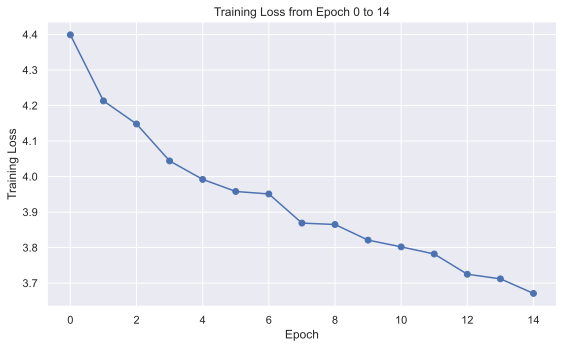

In [78]:
# torch.save(simclr_model.state_dict(), "simclr_manual_epoch15_weights.pth")

epoch_0_14_train_losses = [
    4.399, 4.213, 4.148, 4.044, 3.992,
    3.958, 3.951, 3.869, 3.865, 3.821,
    3.802, 3.782, 3.725, 3.712, 3.671
]
plt.figure(figsize=(8, 5))
plt.plot(range(15), epoch_0_14_train_losses, marker='o')
plt.title("Training Loss from Epoch 0 to 14")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Analysing the encoder performance using tSNE and K means.

- Since this is a self-supervised learning setup (SimCLR), no validation set or validation loss was used during training. The model was trained purely on unlabeled data using contrastive learning objectives. Evaluation of representation quality was done post-training using visualization (t-SNE, UMAP) and clustering metrics (K-Means, ARI, NMI, Accuracy) on labeled data.
- We used t-SNE, a nonlinear dimensionality reduction technique, to project the learned 64-dimensional features into 2D space. The resulting clusters suggest that the encoder has learned to group similar samples (WT vs MUT) effectively.
- Applying K-Means to the encoded features (projected via t-SNE) showed that k=3 surprisingly gave better clustering metrics than k=2, even though we only have 2 true classes. This indicates potential intra-class variation or that one class (e.g., MUT) might be inherently more diverse.

#### We use the trained encoder $f(\cdot)$ to extract feature representations from labeled input data.

In [14]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

# Needed this as Transforms can't augment on 3D views.
class CustomTransform: 
    def __init__(self, target_depth=32):
        self.target_depth = target_depth

    def __call__(self, x):
        # Resize depth (pad or crop)
        d, h, w = x.shape
        if d < self.target_depth:
            pad = self.target_depth - d
            x = F.pad(x, (0, 0, 0, 0, 0, pad))  # Pad front
        elif d > self.target_depth:
            x = x[:self.target_depth]

        # Normalize to [0, 1]
        x = (x - x.min()) / (x.max() - x.min() + 1e-6)

        # Add channel dim if needed (for CNNs)
        x = x.unsqueeze(0)  # [1, D, H, W]
        return x

# custom dataset class to return (tensor,class label)
class NPYClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.class_to_idx = {}
        self.transform = transform

        for i, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            self.class_to_idx[class_name] = i
            for fname in os.listdir(class_path):
                if fname.endswith(".npy"):
                    self.samples.append((os.path.join(class_path, fname), i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)
        data_tensor = torch.tensor(data, dtype=torch.float32)

        if self.transform:
            data_tensor = self.transform(data_tensor)

        return data_tensor, label


# Create dataset and train dataloader for feeding into the trained encoder: 
transform = CustomTransform(target_depth=32)
dataset = NPYClassificationDataset(root_dir="zstacks", transform=transform)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

# model is the Encoder, here we extracted the f(.) and freezed the weights of the model. 
model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=15)
model.load_state_dict(torch.load("simclr_manual_epoch15_weights.pth", map_location="cpu"))
encoder = model.convnet
encoder.eval() 
for param in encoder.parameters():
    param.requires_grad = False

features = []
labels = []
print("Extracting features from data...")
# extracting features from the encoder by feeding in labelled data:
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(loader)):
        #x = x.to(device)
        feats = encoder(x)
        features.append(feats)
        labels.append(y)
        if i % 10 == 0:
            print(f"Batch {i}: Extracted features shape = {feats.shape}")


features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)

print(f"Done! Final feature tensor shape: {features.shape}")
print(f"Labels shape: {labels.shape}")


Extracting features from data...


  1%|▎                                          | 1/122 [00:11<24:00, 11.91s/it]

Batch 0: Extracted features shape = torch.Size([2, 64])


  9%|███▊                                      | 11/122 [02:10<20:47, 11.24s/it]

Batch 10: Extracted features shape = torch.Size([2, 64])


 17%|███████▏                                  | 21/122 [04:32<25:02, 14.88s/it]

Batch 20: Extracted features shape = torch.Size([2, 64])


 25%|██████████▋                               | 31/122 [06:42<18:11, 11.99s/it]

Batch 30: Extracted features shape = torch.Size([2, 64])


 34%|██████████████                            | 41/122 [08:56<17:51, 13.22s/it]

Batch 40: Extracted features shape = torch.Size([2, 64])


 42%|█████████████████▌                        | 51/122 [11:25<16:37, 14.05s/it]

Batch 50: Extracted features shape = torch.Size([2, 64])


 50%|█████████████████████                     | 61/122 [13:34<12:24, 12.20s/it]

Batch 60: Extracted features shape = torch.Size([2, 64])


 58%|████████████████████████▍                 | 71/122 [15:34<11:07, 13.10s/it]

Batch 70: Extracted features shape = torch.Size([2, 64])


 66%|███████████████████████████▉              | 81/122 [18:06<13:17, 19.46s/it]

Batch 80: Extracted features shape = torch.Size([2, 64])


 75%|███████████████████████████████▎          | 91/122 [20:55<10:47, 20.87s/it]

Batch 90: Extracted features shape = torch.Size([2, 64])


 83%|█████████████████████████████████▉       | 101/122 [23:19<05:09, 14.75s/it]

Batch 100: Extracted features shape = torch.Size([2, 64])


 91%|█████████████████████████████████████▎   | 111/122 [25:47<02:56, 16.06s/it]

Batch 110: Extracted features shape = torch.Size([2, 64])


 99%|████████████████████████████████████████▋| 121/122 [27:50<00:11, 11.61s/it]

Batch 120: Extracted features shape = torch.Size([2, 64])


100%|█████████████████████████████████████████| 122/122 [27:53<00:00, 13.71s/it]

Done! Final feature tensor shape: torch.Size([243, 64])
Labels shape: torch.Size([243])


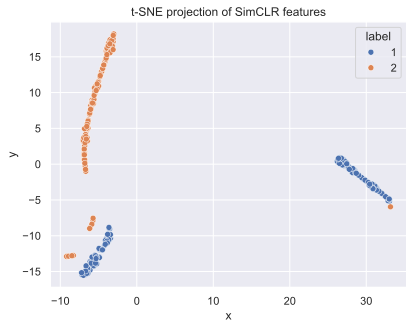

In [77]:
# !pip install scikit-learn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity = 30, random_state=42)
features_2d = tsne.fit_transform(features.numpy())


import seaborn as sns
import pandas as pd

df = pd.DataFrame({
    'x': features_2d[:, 0],
    'y': features_2d[:, 1],
    'label': labels.numpy()
})

sns.scatterplot(data=df, x='x', y='y', hue='label', palette='deep')
plt.title("t-SNE projection of SimCLR features")
plt.show()

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode
import numpy as np


kmeans = KMeans(n_clusters=3, random_state=42)
cluster_preds = kmeans.fit_predict(features.numpy())


def cluster_accuracy(true_labels, cluster_labels):
    labels = np.zeros_like(cluster_labels)
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        most_common = mode(true_labels[mask], keepdims=False).mode
        labels[mask] = most_common
    return (labels == true_labels).mean()


ari = adjusted_rand_score(labels.numpy(), cluster_preds)
nmi = normalized_mutual_info_score(labels.numpy(), cluster_preds)
acc = cluster_accuracy(labels.numpy(), cluster_preds)


print(f"\nKMeans Clustering Results:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
print(f"  Accuracy (after matching):   {acc:.4f}")


KMeans Clustering Results:
  Adjusted Rand Index (ARI): 0.5942
  Normalized Mutual Info (NMI): 0.6055
  Accuracy (after matching):   0.9424


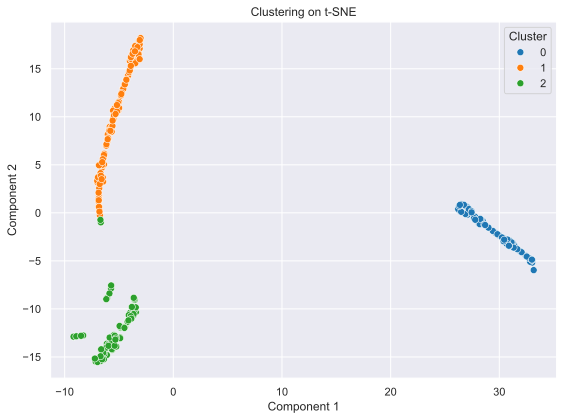

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(embedding_2d, cluster_labels, title='KMeans Clusters'):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding_2d[:, 0],
                    y=embedding_2d[:, 1],
                    hue=cluster_labels,
                    palette='tab10',
                    s=50)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

plot_clusters(features_2d, cluster_preds, title='Clustering on t-SNE')

## Questions 
- Apart from t-SNE visualizations and K-Means clustering, are there any more reliable or recommended methods to evaluate how well the encoder has learned meaningful representations in a self-supervised setting?
- Given that I trained SimCLR for 15 epochs with a small batch size due to hardware limitations,
Should I:
    - Focus on improving the encoder (e.g., by training longer, using a larger batch size),
    - Or proceed with the downstream classification task (e.g., training a linear classifier), and then revisit encoder training based on classification performance?